# First Agent

In [ ]:
from typing import Annotated, Optional, Any

from typing_extensions import TypedDict

from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema import SystemMessage, HumanMessage
from IPython.display import Image, display

import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
from src.rubrics.rubrics import RUBRICS

In [3]:
# class State(TypedDict):
#     messages: Annotated[list, add_messages]

In [4]:
# load_dotenv(override=True)

# os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# llm = init_chat_model("openai:gpt-4o-mini")

In [5]:
# def chatbot(state: State) -> State:
#     return {"messages": [llm.invoke(state["messages"])]}

# graph_builder = StateGraph(State)
# graph_builder.add_node("chatbot", chatbot)
# graph_builder.add_edge(START, "chatbot")
# graph_builder.add_edge("chatbot", END)

# graph = graph_builder.compile()


In [6]:
# def chat(user_input):
#     initial_state = {"messages": [{'role': 'user', 'content': user_input}]}
#     result = graph.invoke(initial_state)
#     return result['messages'][-1].content

# chat("Hello, how are you?")

# State and Structured Output

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

    feedback_on_work: Optional[str]
    rubric: Optional[list]
    candidates: Optional[list[str]]
    # current question id
    current_question_id: Optional[str]

    # score and resoan for current question
    score: Optional[int]
    reason: Optional[str]

    # score and reason for each question
    per_question_scores: Optional[dict[str, dict[str, str | int]]]

    accepted: Optional[bool]
    

# class RubricState(TypedDict):
#     rubric: dict

# class CandidateState(TypedDict):
#     candidates: list[str]
#     answer: str

In [8]:
class CompareOutput(BaseModel):
    score: int
    reason: str

class JudgeOutput(BaseModel):
    accepted: bool


# Initialize LLM

In [9]:
load_dotenv(override=True)

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [10]:
compare_llm = ChatOpenAI(model='gpt-4o-mini')
compare_llm_structured = compare_llm.with_structured_output(CompareOutput)

judge_llm = ChatOpenAI(model='gpt-4o-mini')
judge_llm_structured = judge_llm.with_structured_output(JudgeOutput)

### Define the Helper function

In [62]:
def build_state(question_id: str, candidate_answer: str) -> AgentState:
    messages = [HumanMessage(content=candidate_answer)]
    rubric_info = RUBRICS[question_id]['scoring_levels']
    rubric_text = ""
    for item in RUBRICS[question_id]["scoring_levels"]:
        rubric_text += f"{item['points']} poin: {item['criteria']}\n"
        rubric_text += f"Catatan: {RUBRICS[question_id]['grading_notes']}"


    return {
        'messages': messages,
        'rubric': rubric_text,
        'feedback_on_work': None,
        'candidates': None,
        'current_question_id': question_id,
        'per_question_scores': {},
        'accepted': None,
        'score': None,
        'reason': None,

    }

def attach_main_with_subquestions(subquestions: dict) -> dict:
    result_with_main = {}

    for qid, data in subquestions.items():
        parent = qid[:-1]  # "Q1a" -> "Q1"

        if parent not in result_with_main:
            result_with_main[parent] = {
                "subquestions": {},
                "total_score": 0,
                "passed": None,
            }

        # attach subquestion to the parent
        result_with_main[parent]["subquestions"][qid] = data

        # add total score of parent
        result_with_main[parent]["total_score"] += data["score"]

        # checking to see if pass
        passed = result_with_main[parent]['total_score'] > 3

        result_with_main[parent]['passed'] = passed
    
    return result_with_main
    



### Define the agent function

In [33]:
def compare_node(state: AgentState) -> AgentState:
    system_message =  f"""You are a helpful assistant that compares candidate answers STRICTLY based on the given rubric.
    Be very strict and follow ONLY what the rubric says.
    Do not invent or assume any new rules.
    Give a score exactly as defined by the rubric, and explain briefly why that score fits
    keep your reason short and directly tied to the rubric, do not add anything or hallucinate.

    Here is the rubric:

    {state.get('rubric', '')}
    """

    compare_response = compare_llm_structured.invoke([SystemMessage(content=system_message)] + state['messages'])

    updated_scores = state.get('per_question_scores', {})
    updated_scores[state['current_question_id']] = {
        'score': compare_response.score,
        'reason': compare_response.reason
    }
    
    return { **state, 'score': compare_response.score, 'reason': compare_response.reason, 'per_question_scores': updated_scores }


In [34]:
def judge_node(state: AgentState) -> AgentState:
    system_message = f"""You are a helpful assistant that judges if the reason and score provided by the previous agent aligns with the rubric or not. I want you
    to be very strict about the judge.
    
    Here is the rubric
    {state.get('rubric', '')}
    """

    messages = [HumanMessage(content=f"Score: {state['score']} \n Reason: {state['reason']}")]

    judge_response = judge_llm_structured.invoke([SystemMessage(content=system_message)] + messages)

    current_question_id = state.get('current_question_id', 'unknown')
    updated_scores = dict(state.get('per_question_scores', {}) or {})
    if current_question_id in updated_scores:
        updated_scores[current_question_id]['accepted'] = judge_response.accepted

    return { **state, 'accepted': judge_response.accepted, 'per_question_scores': updated_scores}

    

# Define the Graph

In [35]:
agent_graph = StateGraph(AgentState)

agent_graph.add_node('compare', compare_node)
agent_graph.add_node('judge', judge_node)

agent_graph.add_edge(START, 'compare')
agent_graph.add_edge('compare', 'judge')
agent_graph.add_edge('judge', END)

agent_graph = agent_graph.compile()


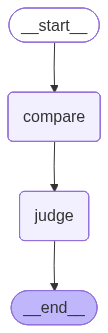

In [36]:
display(Image(agent_graph.get_graph().draw_mermaid_png()))

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

    feedback_on_work: Optional[str]
    rubric: Optional[Any]
    candidates: Optional[list[str]]
    # current question id
    current_question_id: Optional[str]

    # score and resoan for current question
    score: Optional[int]
    reason: Optional[str]

    # score and reason for each question
    per_question_scores: Optional[dict[str, dict[str, str | int]]]

    accepted: Optional[bool]

In [63]:
def chat(state: AgentState):

    result = agent_graph.invoke(state)

    return {'per_question_scores': result['per_question_scores']}

candidate_answers = {
        "Q1a": """
        Produk dan Layanan Utama Telkomsel :
        - Layanan Seluler Prabayar (Kartu Perdana/Voucher Fisik Telkomsel & by.U) dan Pascabayar (Telkomsel Halo)
        -  Layanan Digital (MAXstream, Langit Musik, Dunia Games)
        - Layanan Internet di Rumah (Telkomsel IndiHome & Orbit)
        - Layanan Finansial (LinkAja)""",
        "Q1b": """
        - Mengenali kebutuhan pelanggan dengan mengajukan pertanyaan dasar (Apakah lebih sering menggunakan internet, menelepon, atau SMS?) (Berapa kisaran biaya yang dihabiskan setiap bulannya?) (Lebih sering mengakses media sosial, streaming video, atau bermain games?)
        - Menyesuaikan dengan layanan atau produk Telkomsel
        - Memberikan edukasi kepada pelanggan dengan menjelaskan beberapa pilihan layanan dan produk Telkomsel yang tepat sesuai dengan kebutuhan pelanggan
        """
}

question_ids = ["Q1a", "Q1b"]

answer_results = {}

for qid in question_ids:
    answer_text = candidate_answers[qid]
    state = build_state(qid, answer_text) # build the initial state
    result = chat(state) # graph call
    answer_results[qid] = result['per_question_scores'][qid] # result with every qid

main_results = attach_main_with_subquestions(answer_results)


print(main_results)


{'Q1': {'subquestions': {'Q1a': {'score': 1, 'reason': 'Menjawab dengan benar tentang bisnis mobile dan fixed serta menyebutkan brand terkait, namun tidak menyertakan tipe pelanggan atau detail brand yang lebih spesifik.', 'accepted': True}, 'Q1b': {'score': 1, 'reason': 'Jawaban menunjukkan pemahaman dasar tentang identifikasi kebutuhan pelanggan melalui pertanyaan, tetapi tidak ada analisis tambahan atau asumsi eksplisit yang melengkapi rekomendasi produk. Penjelasan masih tergolong umum dan tidak sepenuhnya actionable.', 'accepted': False}}, 'total_score': 2, 'passed': False}}


In [17]:
tes = RUBRICS['Q1a']['scoring_levels']
tes

[{'points': 2,
  'criteria': 'Menjelaskan dengan lengkap bisnis mobile & fixed, menyebutkan brand di dalamnya, serta menambahkan tipe pelanggan dan detail brand.'},
 {'points': 1,
  'criteria': 'Menyebutkan dengan benar bisnis mobile & fixed dan brand di dalamnya, namun kurang lengkap (tidak menjelaskan tipe pelanggan atau detail brand).'},
 {'points': 0,
  'criteria': 'Tidak dapat menjelaskan produk dan layanan utama Telkomsel secara benar.'}]

a. Produk dan Layanan Utama Telkomsel :
- Layanan Seluler Prabayar (Kartu Perdana/Voucher Fisik Telkomsel & by.U) dan Pascabayar (Telkomsel Halo)
-  Layanan Digital (MAXstream, Langit Musik, Dunia Games)
- Layanan Internet di Rumah (Telkomsel IndiHome & Orbit)
- Layanan Finansial (LinkAja)

b. - Mengenali kebutuhan pelanggan dengan mengajukan pertanyaan dasar (Apakah lebih sering menggunakan internet, menelepon, atau SMS?) (Berapa kisaran biaya yang dihabiskan setiap bulannya?) (Lebih sering mengakses media sosial, streaming video, atau bermain games?)
- Menyesuaikan dengan layanan atau produk Telkomsel
- Memberikan edukasi kepada pelanggan dengan menjelaskan beberapa pilihan layanan dan produk Telkomsel yang tepat sesuai dengan kebutuhan pelanggan